In [1]:
!pip install tables

In [2]:
import tables
import numpy as np
import datetime

In [3]:
properties=tables.open_file('trail_properties.h5')
print(properties)

trail_properties.h5 (File) ''
Last modif.: '2023-03-22T11:41:52+00:00'
Object Tree: 
/ (RootGroup) ''
/N_track (CArray(5451,)zlib(9)) ''
/avg_brightness (CArray(5451,)zlib(9)) ''
/duration (CArray(5451,)zlib(9)) ''
/max_brightness (CArray(5451,)zlib(9)) ''
/nrun (CArray(5451,)zlib(9)) ''
/start (CArray(5451,)zlib(9)) ''
/t0 (CArray(5451,)zlib(9)) ''
/time_in_night (CArray(5451,)zlib(9)) ''
/unique_pix (CArray(5451,)zlib(9)) ''
/velocity (CArray(5451,)zlib(9)) ''
/zenith (CArray(5451,)zlib(9)) ''



In [4]:
print(properties.root['N_track'].read())
print(properties.root['nrun'].read())

[-1. -1. -1. ...  0.  1.  0.]
[155172 155173 155174 ... 180349 180349 180379]


In [5]:
!pip install sshtunnel

In [6]:
import sys
import paramiko
import pandas as pd
import json
import sshtunnel
import mariadb
import sys
import paramiko
import datetime
from datetime import timedelta
import numpy as np
import math
import re

def getMdbCursor():
    conn = mariadb.connect(
        user="spencers",
        password="GieLope9ohquaep3xi",
        host='127.0.0.1',
        port=12345,
        database="HD_tables"
    )

    # Instantiate Cursor
    cur = conn.cursor()
    return cur

def load_collection(CMD):
    cur = getMdbCursor()
    print(CMD)
    cur.execute(CMD)
    df = pd.DataFrame(cur.fetchall())
    column_title = re.search('SELECT(.*)FROM', CMD)
    df.columns = list(column_title.group(1).replace(" ", "").split(","))
    return df

def getCollForStat(col):
    allCols = getMdbCursor()
    allCols.execute('SHOW COLUMNS FROM '+ 'HD_test'+'.'+col)
    cols = allCols.fetchall()

    list_allCols = []
    for i in  range(len(cols)):
        list_allCols = list_allCols + [cols[i][0]]
    list_allCols_str =  ','.join(list_allCols[1:])
    cur = getMdbCursor()
    CMD = "SELECT " + list_allCols_str +" FROM HD_test."+col+" WHERE Run > 100 ORDER BY HD_test."+col+".WhenEntered asc"
    cur.execute(CMD)
    df = pd.DataFrame(cur.fetchall())
    df_atm =  df
    df_atm.columns = list_allCols[1:]
    #df_atm = df_atm.drop_duplicates(['Run','Telescope'],keep='last')

    df_atm =df_atm.merge(df_run, on=['Run'])

    df_atm['Year'] = [e.year  for e in list(df_atm['TimeOfStart'])]
    df_atm['Month'] = [e.month  for e in list(df_atm['TimeOfStart'])]
    df_atm['doy'] = [e.timetuple().tm_yday for e in list(df_atm['TimeOfStart'])]
    df_atm['Nrun']=1
    df_atm.groupby(['Month']).sum()
    return df_atm


CMD = "SELECT Run, Target_Name FROM  HD_test.Monitor_Run_Analysis"
df_run = load_collection(CMD)
df_run.columns = ['Run', 'Target']
df_run = df_run.drop_duplicates(['Run'],keep='last')

CMD = "SELECT Run, Duration, Run_Start_Time FROM  HD_test.Monitor_Run_Data"
df_run = load_collection(CMD)
df_run.columns = ['Run', 'Run_Duration', 'Run_Start_Time']
df_run = df_run.drop_duplicates(['Run'],keep='last')

CMD = "SELECT Run, TransparencyCoefficient_mean FROM  HD_test.Monitor_Run_Atmosphere"
df_atmo = load_collection(CMD)
df_atmo.columns = ['Run', 'TransparencyCoefficient_mean']
df_atmo = df_atmo.drop_duplicates(['Run'],keep='last')
df_run = df_run.merge(df_atmo,left_on='Run',right_on='Run')

CMD = "SELECT Run, RA_mean, Dec_mean FROM  HD_test.Monitor_Run_Tracking"
df_track = load_collection(CMD)
df_track.columns = ['Run', 'RA_mean','Dec_mean']
df_track = df_track.drop_duplicates(['Run'],keep='last')
df_run = df_run.merge(df_track,left_on='Run',right_on='Run')

CMD = "SELECT Run, Telescope, Ped_NSB_mean, Ped_NSB_rms FROM  HD_test.Monitor_Run_Pixel"
df_nsb = load_collection(CMD)
df_nsb.columns = ['Run', 'Telescope','Ped_NSB_mean','Ped_NSB_rms']
df_nsb = df_nsb.drop_duplicates(['Run','Telescope'],keep='last')
df_ct5 = df_nsb[['Run','Ped_NSB_mean']][df_nsb['Telescope']==5].copy(deep=True)
df_ct5 = df_ct5.rename(columns={'Ped_NSB_mean':'Ped_NSB_CT5'})
df_nsb = df_nsb.merge(df_ct5,left_on='Run',right_on='Run')
df_run = df_run.merge(df_nsb,left_on=['Run'],right_on=['Run'])
print('nsb',df_run)

CMD = "SELECT Run, Telescope, Efficiency_mean, Efficiency_rms FROM  HD_test.Monitor_Run_Muon"
df_muon = load_collection(CMD)
df_muon.columns = ['Run', 'Telescope', 'Efficiency_mean', 'Efficiency_rms']
df_muon = df_muon.drop_duplicates(['Run','Telescope'],keep='last')
print('mu',df_muon)
df_ct5 = df_muon[['Run','Efficiency_mean']][df_muon['Telescope']==5].copy(deep=True)
df_ct5 = df_ct5.rename(columns={'Efficiency_mean':'Efficiency_CT5'})
print(df_ct5)
df_muon = df_muon.merge(df_ct5,left_on='Run',right_on='Run')
print('mu2',df_muon)
df_run = df_run.merge(df_muon,left_on=['Run','Telescope'],right_on=['Run','Telescope'])
print('nsb',df_run)

SELECT Run, Target_Name FROM  HD_test.Monitor_Run_Analysis
SELECT Run, Duration, Run_Start_Time FROM  HD_test.Monitor_Run_Data
SELECT Run, TransparencyCoefficient_mean FROM  HD_test.Monitor_Run_Atmosphere
SELECT Run, RA_mean, Dec_mean FROM  HD_test.Monitor_Run_Tracking
SELECT Run, Telescope, Ped_NSB_mean, Ped_NSB_rms FROM  HD_test.Monitor_Run_Pixel
nsb            Run  Run_Duration      Run_Start_Time  \
0       141016         407.0 2018-08-10 00:55:13   
1        41742        1688.0 2007-09-14 21:22:01   
2        41742        1688.0 2007-09-14 21:22:01   
3        41742        1688.0 2007-09-14 21:22:01   
4        41742        1688.0 2007-09-14 21:22:01   
...        ...           ...                 ...   
111249  182221        1683.0 2023-05-15 03:00:10   
111250  182221        1683.0 2023-05-15 03:00:10   
111251  182221        1683.0 2023-05-15 03:00:10   
111252  182221        1683.0 2023-05-15 03:00:10   
111253  182221        1683.0 2023-05-15 03:00:10   

        Transparency

In [7]:
tracks=properties.root['N_track'].read()+1
nrun=properties.root['nrun'].read()
t0=properties.root['t0'].read()
avg_brightness=properties.root['avg_brightness'].read()
duration=properties.root['duration'].read()
max_brightness=properties.root['max_brightness'].read()
trailstart=properties.root['start'].read()
unique_pix=properties.root['unique_pix'].read()
velocity=properties.root['velocity'].read()
zenith=properties.root['zenith'].read()
df_tracks=pd.DataFrame({'Run':nrun,'Tracks':tracks,'t0':t0,'avg_brightness':avg_brightness,'duration':duration,'max_brightness':max_brightness,'trailstart':trailstart,'unique_pix':unique_pix,'velocity':velocity,'zenith':zenith})
print(df_tracks)


         Run  Tracks            t0  avg_brightness  duration  max_brightness  \
0     155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
1     155173     0.0  1.572304e+09            -1.0      -1.0            -1.0   
2     155174     0.0  1.572306e+09            -1.0      -1.0            -1.0   
3     155179     0.0  1.572314e+09            -1.0      -1.0            -1.0   
4     155246     0.0  1.572391e+09            -1.0      -1.0            -1.0   
...      ...     ...           ...             ...       ...             ...   
5446  180348     4.0  1.675219e+09          1887.7       4.8          4371.2   
5447  180348     5.0  1.675219e+09          1189.9       4.7          1616.3   
5448  180349     1.0  1.675221e+09          1835.8       4.5          4006.5   
5449  180349     2.0  1.675221e+09          1103.4       4.7          1438.9   
5450  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   

        trailstart  unique_pix  velocit

In [8]:
df_tracks=df_tracks.merge(df_run,left_on='Run',right_on='Run')
print(df_tracks)

          Run  Tracks            t0  avg_brightness  duration  max_brightness  \
0      155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
1      155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
2      155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
3      155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
4      155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
...       ...     ...           ...             ...       ...             ...   
27250  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   
27251  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   
27252  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   
27253  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   
27254  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   

         trailstart  unique

In [9]:
df_backup=df_tracks.copy(deep=True)
df_tracks=df_tracks[df_tracks['Tracks']!=0]
print(len(df_tracks['Tracks']))

8290


In [10]:
!pip install healpy pyyaml requests

In [11]:
!pip install git+https://github.com/desihub/desiutil.git

  Cloning https://github.com/desihub/desiutil.git to /tmp/pip-req-build-q7ewn8g1
  Running command git clone --filter=blob:none --quiet https://github.com/desihub/desiutil.git /tmp/pip-req-build-q7ewn8g1
  Resolved https://github.com/desihub/desiutil.git to commit a15f4f98214d14ad05e740d68f333994dfa1f1f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 72.9 MB/s eta 0:00:00m eta 0:00:010:01:01
  Created wheel for desiutil: filename=desiutil-3.3.1.dev1029-py3-none-any.whl size=1070334 sha256=88288d495140085473fae971a77ef2af94f0d2356fd4444541432536f312c51a
  Stored in directory: /tmp/pip-ephem-wheel-cache-s757tago/wheels/34/09/8b/d13aa456065b087d9abe0f662176febb98d659764200f53d78
Successfully built desiutil
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled nu

In [12]:
from desiutil.plots import prepare_data, init_sky, plot_grid_map, plot_healpix_map, plot_sky_circles,plot_sky_binned
import matplotlib.pyplot as plt
import matplotlib

Using 82 x 252 grid in cos(DEC) x RA with pixel area 1.996 sq.deg.


<Figure size 2000x1000 with 0 Axes>

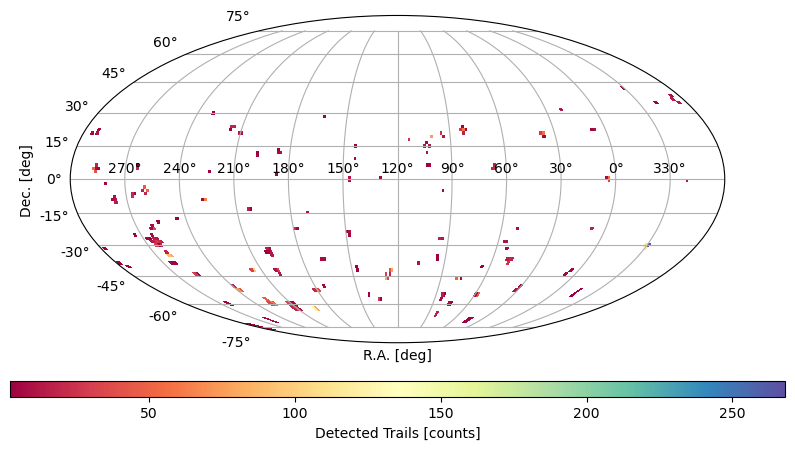

In [13]:
fig=plt.figure(figsize=(20,10))
ax = plot_sky_binned(df_tracks['RA_mean'], df_tracks['Dec_mean'], label='Detected Trails [counts]',galactic_plane_color=None, ecliptic_plane_color=None,cmap='Spectral',verbose=True,max_bin_area=2,clip_lo='!1')
#ax.grid(False)
#ax.set_xticklabels([])
plt.savefig('trails.png',dpi=300)

In [14]:
!pip install scipy
from scipy import stats

In [15]:
df_copy=df_run.merge(df_tracks.drop_duplicates('Run',keep='last'), on=['Run','Run'], how='left', indicator=True)
df_run=df_run[df_copy['_merge'] == 'left_only'] # Drop runs in track database
print(df_run)

           Run  Run_Duration      Run_Start_Time  \
0       141016         407.0 2018-08-10 00:55:13   
1        74036         609.0 2012-07-13 22:56:09   
2        74036         609.0 2012-07-13 22:56:09   
3        74036         609.0 2012-07-13 22:56:09   
4        74036         609.0 2012-07-13 22:56:09   
...        ...           ...                 ...   
109108  182221        1683.0 2023-05-15 03:00:10   
109109  182221        1683.0 2023-05-15 03:00:10   
109110  182221        1683.0 2023-05-15 03:00:10   
109111  182221        1683.0 2023-05-15 03:00:10   
109112  182221        1683.0 2023-05-15 03:00:10   

        TransparencyCoefficient_mean     RA_mean  Dec_mean  Telescope  \
0                           1.001572    0.525048  -3.42527          5   
1                           0.000000  265.576000 -83.26560          1   
2                           0.000000  265.576000 -83.26560          2   
3                           0.000000  265.576000 -83.26560          3   
4         

selfcorr PearsonRResult(statistic=-0.5137708629869148, pvalue=5.368879869277411e-08)
0.0014285714285714284 0.00024259559488992946 0.0014285714285714286 0.0002217786000082919


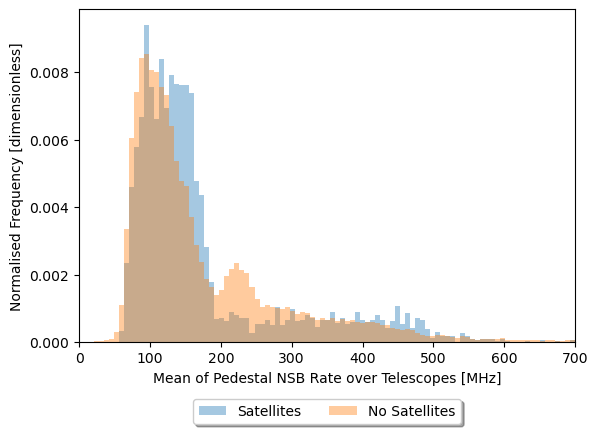

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
x1,edges1,patches1=plt.hist(df_tracks['Ped_NSB_mean'],bins=np.linspace(0,700,100),alpha=0.4,label='Satellites',density=True)
x2,edges2,patches2=plt.hist(df_run[df_run['Run']>155336]['Ped_NSB_mean'],bins=np.linspace(0,700,100),alpha=0.4,label='No Satellites',density=True)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
xcenters1 = (edges1[:-1] + edges1[1:]) / 2

ax.set_xlabel('Mean of Pedestal NSB Rate over Telescopes [MHz]')
ax.set_ylabel('Normalised Frequency [dimensionless]')
plt.xlim(0,700)
ax.set_title('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('pedestal.png',dpi=300)
print('selfcorr',stats.pearsonr(x1,xcenters1))
print(np.mean(x1),np.std(x1)/np.sqrt(len(x1)),np.mean(x2),np.std(x2)/np.sqrt(len(x2)))

selfcorr PearsonRResult(statistic=0.08601547390206457, pvalue=0.3972492248538439)
0.0014285714285714281 0.00016068004649972523 0.0014285714285714286 0.0001468820542106574


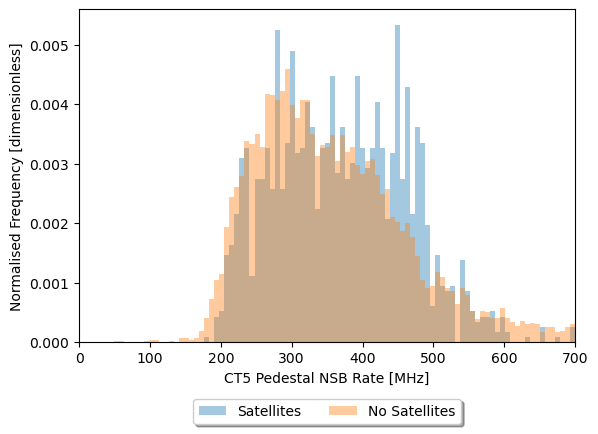

In [17]:
fig = plt.figure()
ax = plt.subplot(111)
x1,xedges1,patches1=plt.hist(df_tracks['Ped_NSB_CT5'],bins=np.linspace(0,700,100),alpha=0.4,label='Satellites',density=True)
x2,xeges2,patches2=plt.hist(df_run[df_run['Run']>155336]['Ped_NSB_CT5'],bins=np.linspace(0,700,100),alpha=0.4,label='No Satellites',density=True)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
xcenters1 = (edges1[:-1] + edges1[1:]) / 2

ax.set_xlabel('CT5 Pedestal NSB Rate [MHz]')
ax.set_ylabel('Normalised Frequency [dimensionless]')
plt.xlim(0,700)
ax.set_title('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('pedestalCT5.png',dpi=300)
print('selfcorr',stats.pearsonr(x1,xcenters1))
print(np.mean(x1),np.std(x1)/np.sqrt(len(x1)),np.mean(x2),np.std(x2)/np.sqrt(len(x2)))

selfcorr PearsonRResult(statistic=0.004203665834336767, pvalue=0.9670607792760307)
0.5 0.1518846106679049 0.5 0.09611646801847722


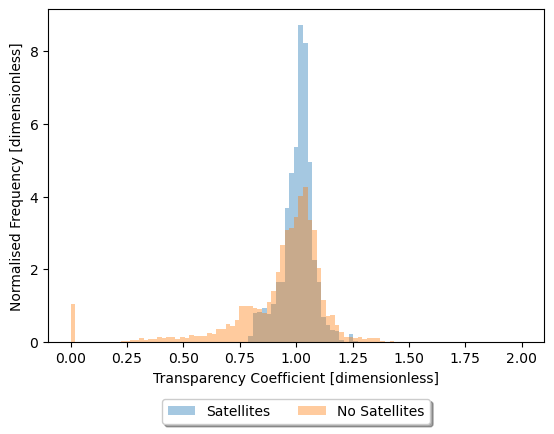

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
x1,xedges1,patches1=plt.hist(df_tracks['TransparencyCoefficient_mean'],bins=np.linspace(0,2,100),alpha=0.4,label='Satellites',density=True)
x2,xedges2,patches2=plt.hist(df_run[df_run['Run']>155336]['TransparencyCoefficient_mean'],bins=np.linspace(0,2,100),alpha=0.4,label='No Satellites',density=True)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
xcenters1 = (edges1[:-1] + edges1[1:]) / 2

ax.set_xlabel('Transparency Coefficient [dimensionless]')
ax.set_ylabel('Normalised Frequency [dimensionless]')
ax.set_title('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('tc.png',dpi=300)
print('selfcorr',stats.pearsonr(x1,xcenters1))
print(np.mean(x1),np.std(x1)/np.sqrt(len(x1)),np.mean(x2),np.std(x2)/np.sqrt(len(x2)))

selfcorr PearsonRResult(statistic=-0.10867699533327083, pvalue=0.2842753011889283)
13.333333333333346 1.8432906382769503 13.333333333333341 1.6491170680311669


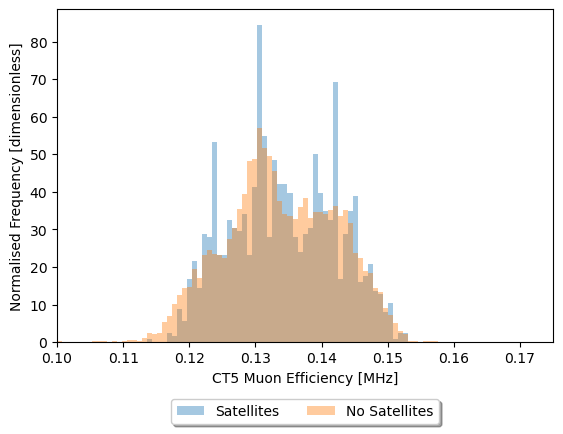

In [19]:
fig = plt.figure()
ax = plt.subplot(111)
#np.linspace(0.06,0.1,100)
x1,xedges1,patches1=plt.hist(df_tracks['Efficiency_CT5'],bins=np.linspace(0.100,0.175,100),alpha=0.4,label='Satellites',density=True)
x2,xedges2,patches2=plt.hist(df_run[df_run['Run']>155336]['Efficiency_CT5'],bins=np.linspace(0.100,0.175,100),alpha=0.4,label='No Satellites',density=True)
xcenters1 = (edges1[:-1] + edges1[1:]) / 2

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.set_xlabel('CT5 Muon Efficiency [MHz]')
ax.set_ylabel('Normalised Frequency [dimensionless]')
plt.xlim(0.1,0.175)
ax.set_title('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('meCT5.png',dpi=300)
print('selfcorr',stats.pearsonr(x1,xcenters1))
print(np.mean(x1),np.std(x1)/np.sqrt(len(x1)),np.mean(x2),np.std(x2)/np.sqrt(len(x2)))

In [20]:
print(df_tracks['avg_brightness'].argmax())

2925


In [32]:
df_tracks_release=df_tracks[df_tracks['Telescope']==5]
df_tracks_release=df_tracks_release.drop(columns=['Ped_NSB_mean','Ped_NSB_rms','Efficiency_mean','Efficiency_rms','Telescope'])
print(df_tracks_release)
df_tracks_release.to_csv('trail_data_release.csv',index=False)

          Run  Tracks            t0  avg_brightness  duration  max_brightness  \
34     155336     1.0  1.572489e+09          5391.8       4.7         16877.7   
54     155398     1.0  1.572746e+09          2153.6       4.8          5842.9   
79     155982     1.0  1.574364e+09          2111.5       9.7          5206.6   
84     155982     2.0  1.574364e+09          1042.9       3.0          1215.4   
89     155983     1.0  1.574365e+09          1522.3       6.9          2902.6   
...       ...     ...           ...             ...       ...             ...   
27234  180348     4.0  1.675219e+09          1887.7       4.8          4371.2   
27239  180348     5.0  1.675219e+09          1189.9       4.7          1616.3   
27244  180349     1.0  1.675221e+09          1835.8       4.5          4006.5   
27249  180349     2.0  1.675221e+09          1103.4       4.7          1438.9   
27254  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   

         trailstart  unique

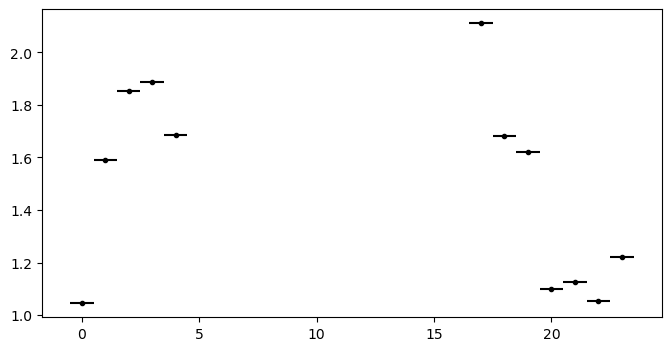

In [22]:
import matplotlib.dates as mdates
meanvals=[]
starttimes=np.arange(24)
errs=[]

for i in starttimes:
    x=df_tracks.loc[df_tracks['Run_Start_Time'].dt.hour==i,['Tracks']].mean()
    errs=df_tracks.loc[df_tracks['Run_Start_Time'].dt.hour==i,['Tracks']].std()/np.sqrt(len(df_tracks.loc[df_tracks['Run_Start_Time'].dt.hour==i,['Tracks']]))
    meanvals.append(x)

fig=plt.figure(figsize=(8,4))
plt.errorbar(starttimes,meanvals,color='black',xerr=0.5,linestyle='None',marker='.')

plt.show()